In [1]:
## parameters for experiment
N_BLOCK = 5
#LR = 0.00001
LR = 0.001

OUTPUT_DIR = '20251022-MultiDecoderNetv2'
RANDOM_SEED = 42

IN_CHANNEL = 1
OUT_CHANNEL = 11

AUGMENTED = True
AUGMENTATION  =  30


CROSS_VAL = True
N_SPLIT = 4


#optimization constants
DICE_IMPORTANCE = 1.0
CE_IMPORTANCE = 1.0

In [2]:
## import libraries
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet4
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2025-10-22 14:01:58.578029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 14:01:59.284936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## random seed config
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(RANDOM_SEED)

# Set seed for NumPy
np.random.seed(RANDOM_SEED)

# Set seed for PyTorch
torch.manual_seed(RANDOM_SEED)

# If you are using GPU
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [4]:
## cuda and pytorch stats
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [5]:
## file_names_with_prefix
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [6]:
## paths config
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
#date_str = '20241202-Conv1x1-' + str(OUTPUT_DIR)
date_str = OUTPUT_DIR

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug")


# data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcOriginal")
# feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcFeature") 
# labeled_dir = str(root_dir / "img_1006t/labeled")

# augmented_labeled_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCLabel")
# augmented_data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCOriginal")
# augmented_feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCFeature")

# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []


# for raw_input_img in INPUT:
#     input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
# for raw_val_img in VALIDATION:
#     input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
# for raw_anneal in ANNEALING:
#     annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
# for raw_test in TEST:
#     test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
# print(input_train)
# print(input_name_val)
# print(annealing_input_name)
# print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


# print(len(input_train))

# print(len(input_name_val))
# print(len(test_input_name))
# print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20251022-MultiDecoderNetv2
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2


In [7]:
## feature list definition
# 特徴画像の特徴一覧をリストとして取得#
#inputfeature_list = list(map(str, InputFeature))
inputfeature_list = ['CLA_']

# inputfeature_list = ["GRY_", "NML1", "NML2", "NML3", "NML1", "MEA1",
#                      "MEA2", "MED1", "MED2", "NML1", "NGP_", "KNN1",
#                      "KNN2", "BLT1", "BLT2", "UNS1", "UNS2", "UNS3",
#                      "UNS4", "UNS5", "ERO1", "ERO2", "ERO3", "ERO4",
#                      "ERO5", "ERO6", "OPN1", "OPN2", "OPN3", "OPN4",
#                      "OPN5", "CLO1", "CLO2", "CLO3", "CLO4", "CLO5",
#                      "MIN1", "MIN2", "MIN3", "MIN4", "MAX1", "MAX2",
#                      "MAX3", "MAX4", "MRL1", "MRL2", "MRL3", "MRL4",
#                      "RIC_",
#                      ]



# unet only
#inputfeature_list = inputfeature_list[:1]

#inputfeature_list.clear()

#inputfeature_list.append("RIC_")
#print(inputfeature_list)

#inputfeature_list.remove(OUTPUT_DIR[-4:])
# inputfeature_list.remove("TOP1")
# inputfeature_list.remove("TOP2")
# inputfeature_list.remove("TOP3")
# inputfeature_list.remove("TOP4")

# inputfeature_list.remove("SBLX")
# inputfeature_list.remove("SBLY")
# inputfeature_list.remove("SBLM")
# inputfeature_list.remove("SBLD")
# inputfeature_list.remove("SBL1")
# inputfeature_list.remove("SBL2")
# inputfeature_list.remove("SBL3")
# inputfeature_list.remove("SBL4")

# inputfeature_list.remove("LPL1")
# inputfeature_list.remove("LPL2")

# inputfeature_list.remove("LBP1")
# inputfeature_list.remove("LBP2")
# inputfeature_list.remove("LBP3")

# inputfeature_list.remove("SOL_")
# inputfeature_list.remove("OOO_")

# inputfeature_list.remove("CAN1")
# inputfeature_list.remove("CAN2")
# inputfeature_list.remove("CAN3")


# inputfeature_list.remove("FOU1")
# inputfeature_list.remove("FOU2")
# inputfeature_list.remove("FOU3")
# inputfeature_list.remove("FOU4")

# inputfeature_list.remove("SCH1")
# inputfeature_list.remove("SCH2")
# inputfeature_list.remove("SCH3")
# inputfeature_list.remove("SCH4")

# inputfeature_list.remove("ROB1")
# inputfeature_list.remove("ROB2")
# inputfeature_list.remove("ROB3")
# inputfeature_list.remove("ROB4")

# inputfeature_list.remove("MRG1")
# inputfeature_list.remove("MRG2")
# inputfeature_list.remove("MRG3")
# inputfeature_list.remove("MRG4")

# inputfeature_list.remove("BTM1")
# inputfeature_list.remove("BTM2")
# inputfeature_list.remove("BTM3")
# inputfeature_list.remove("BTM4")

# inputfeature_list.remove("DST_")
# inputfeature_list.remove("HOM_")

# for i in range(108):
#     stckd_feature_name = "NGP_" + inputfeature_list[i]
#     inputfeature_list.append(stckd_feature_name)

# for input_feature in inputfeature_list[:]:
#     if not input_feature.startswith("NGP"):
#         inputfeature_list.remove(input_feature)
        


print(inputfeature_list)
feature_num = len(inputfeature_list)


print(feature_num)

['CLA_']
1


In [8]:
## createweightimage read by images
# takes too much memory cuz it loads all images into np array at once


## 重み計算なし
def CreateWeightImage(input_number, augmentation=False):
    print("Creating image arrays...")
    
    arrDataset = []
    labeled_image = []
    for j in range(OUT_CHANNEL - 1):
        label_dataset = []
        for i in input_number:
            if augmentation:
                label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
            else:
                label_path = os.path.join(labeled_dir, f"{i}.png")
            input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            
            labeled_image_j = np.where(input_originallabel == j + 1, 1, 0).astype(np.float32)
                    
            label_dataset.append(labeled_image_j)
        labeled_image.append(label_dataset)
    

    print("Number of label images:", len(label_dataset))


    
    for i in input_number:
        # changed this part from 100 to 256

        dataset_img =  np.zeros((256, 256, feature_num), dtype=np.float32)
            
            
        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg

        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("Completed creating image arrays:")
    print("Dataset shape ", arrDataset.shape)
    print("Label image shape ", np.shape(label_dataset))
    print()

    return arrDataset, labeled_image


In [9]:
## createweightimagenew read paths only
def CreateWeightImageNew(input_numbers, augmentation=False):
    print("Creating image paths...")
    label_paths = []
    feature_paths = []

    for i in input_numbers:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/", f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        label_paths.append(label_path)

        feature_img_paths = []
        for feature_name in inputfeature_list:
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/", str(i), f"{feature_name}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{feature_name}.png")
            feature_img_paths.append(feature_img_path)

        feature_paths.append(feature_img_paths)

    print(f"Processed {len(label_paths)} label paths and {len(feature_paths)} feature paths.")
    return feature_paths, label_paths


In [10]:
## create weight test example

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [11]:
## createweightimageforshow
# # # 重みを基づいて、MC画像を生成する
# # # function for showing MC image
# # # gets 1d array as weight, input_number is image name, and index is directory name for the mc image to save
# def CreateWeightImageforShow(weight, input_number, index):
#     sum_weight = sum(weight)  # Calculate total weight

#     label_dataset = []
#     input_dataset = []
#     dataset_original = []

#     # Read label images
#     for i in input_number:
#         input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
#         label_dataset.append(input_originallabel)

#     print('Weight image for show, label length = ', len(label_dataset))

#     # Create output directory
#     os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

#     # Generate weighted images
#     for i in input_number:
#         # Create a blank image to store the weighted image, using float type for accumulation
#         dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
#         input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

#         dataset_original.append(input_originalimg)
#         for m in range(feature_num):
#             input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
#             # Normalize the feature image
#             normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
#             # Accumulate the weighted feature image
#             dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

#         # Normalize the accumulated image to the range 0-255
#         dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
#         output_img = dataset_img.astype(np.uint8)  # Convert to uint8

#         input_dataset.append(output_img)
#         # Write to file
#         cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

#     return input_dataset, label_dataset


In [12]:
## value extraction for visual mc
# # ## Netron app to extract the weight tensor
# # ## if the conv is 1x1 the tensor has 45 values
# # ## if the conv is 3x3 there are 9 x 45 values so the function averages 9 value into 1 and so on
# def compute_mean_values(input_list):
#     """
#     Compute mean of 3x3 blocks in each channel of the input list.
    
#     Args:
#         input_list (list): A 4D list of shape (1, C, H, W).
        
#     Returns:
#         list: A 1D list of length C containing the mean values for each channel.
#     """
#     # Ensure the input is a 4D list
#     if not isinstance(input_list, list) or len(input_list) != 1:
#         raise ValueError("Expected input list of shape (1, C, H, W)")
    
#     channels = input_list[0]  # Get the channels (C, H, W)
    
#     if not isinstance(channels, list) or not all(isinstance(channel, list) for channel in channels):
#         raise ValueError("Each channel must be a list of 2D lists (H, W).")
    
#     mean_values = []
#     for channel in channels:
#         if not all(isinstance(row, list) for row in channel):
#             raise ValueError("Each channel must contain 2D lists.")
        
#         # Flatten the 2D channel to compute the mean
#         flattened = [value for row in channel for value in row]
#         mean_values.append(sum(flattened) / len(flattened))
    
#     return mean_values


In [13]:
## mc image visualization example
# ### 1X1-1029-23-n1-1
# ### JUST SINGLE VARIATION
# weight_tensor_1x1_1029_23_n1_1_example = [
#     [
#         [
#             [
#                 0.048620592802762985
#                 ...
#     ]
# ]

# input_number = ['N1-1']

# #single
# weight_cn = compute_mean_values(weight_tensor_1x1_1029_23_n1_1)

# weight_cn1 = compute_mean_values(weight_tensor_1x1_1029_36_n1_1)
# weight_cn2 = compute_mean_values(weight_tensor_3x3_1_1029_36_n1_1)
# weight_cn3 = compute_mean_values(weight_tensor_3x3_2_1029_36_n1_1)
# weight_cn4 = compute_mean_values(weight_tensor_5x5_1_1029_36_n1_1)
# weight_cn5 = compute_mean_values(weight_tensor_5x5_2_1029_36_n1_1)

# print(len(weight_cn))
# print(len(weight_cn1))
# print(len(weight_cn2))
# print(len(weight_cn3))
# print(len(weight_cn4))
# print(len(weight_cn5))

# CreateWeightImageforShow(weight_cn, input_number, "single")

# CreateWeightImageforShow(weight_cn1, input_number, "multiple1x1")
# CreateWeightImageforShow(weight_cn2, input_number, "multiple3x3-1")
# CreateWeightImageforShow(weight_cn3, input_number, "multiple3x3-2")
# CreateWeightImageforShow(weight_cn4, input_number, "multiple5x5-1")
# CreateWeightImageforShow(weight_cn5, input_number, "multiple5x5-2")



In [14]:
## mc image visualization example
# weight_tensor = np.load("/home/eric/Documents/cervicalResearchIIP/result_test/20250420-MCU-Net-108/0420_MCU108_fold4_w.npy")

# # initial shape (3, 108, 3, 3) (out_channels, channels, height_convolution, width_convolution)
# # np.mean takes mean value of out_channels
# # [np.newaxis, :] shapes into (1, 108, 3, 3)
# weight_tensor = np.mean(weight_tensor, axis = 0)[np.newaxis, :]
# weight_tensor = weight_tensor.tolist()

# #f1
# #input_number = ["N1-1", "N1-7", "N1-9", "N2-3", "N2-7", "N2-10", "N3-1", "N3-8", "N3-10", "N4-8", "N5-4"]
# #f2
# #input_number = ["N1-2", "N1-5", "N1-10", "N2-4", "N3-2", "N3-4", "N3-5", "N3-9", "N4-3", "N4-9", "N5-2"]
# #f3
# #input_number = ["N1-3", "N1-4", "N1-10", "N2-1", "N2-5", "N2-8", "N3-3", "N3-7", "N4-4", "N4-5", "N4-6", "N5-1", "N5-6"]
# #f4
# input_number = ["N1-6", "N1-8", "N2-2", "N2-6", "N2-9", "N3-6", "N4-1", "N4-2", "N4-7", "N5-3", "N5-5"]

# # weight_tensor_converted = weight_tensor[0].tolist()

# # weight_tensor_dv1 = [weight_tensor_converted]
# # # print(weight_tensor_dv1.shape)
# weight_cn  = compute_mean_values(weight_tensor)

# CreateWeightImageforShow(weight_cn, input_number, "fold4")

In [15]:
## minor irrelevant function
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [16]:
## preprocess and postprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
# def postprocess(img: torch.tensor):
#     img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
#     #img = img * 255.0 commented as the labels are from 0 to 11 in my case
#     img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
#     # If batch_size > 1, you may need to loop through each batch and save them separately
#     # If batch_size == 1, you can remove the batch dimension to save a single image

#     # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
#     #print("in post")
#     #print(np.unique(img))


#     img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
#     # img = re_normalize(img)  # Scale it to the range [0-255]

#     # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
#     # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
#     # If C == 1, you can further reduce dimensions -> [H, W]
#     if img.shape[0] == 3:  # [C, H, W]
#         img = np.transpose(img, (1, 2, 0))  # [H, W, C]
#         img = img[:, :, ::-1]  # Convert RGB to BGR
#     elif img.shape[0] == 1:  # [C, H, W]
#         img = np.squeeze(img, 0)  # [H, W]
#     return img

def postprocess(outputs: list[torch.Tensor]):
    """
    Ensembles multiple softmaxed output tensors into a single segmentation mask.

    Args:
        outputs: list of softmaxed tensors, each of shape [B, C, H, W]
                 (probabilities from each decoder)
    Returns:
        numpy array segmentation mask [H, W] or [B, H, W]
    """
    
    pred_masks = []
    for decoder_out in outputs:  # each [B, C, H, W]
        # if decoder has 2 classes: 0=background, 1=object
        pred_mask = torch.argmax(decoder_out, dim=1)  # [B, H, W]
        pred_masks.append(pred_mask)
            
    combined_mask = torch.zeros_like(pred_masks[0])
    for i, mask in enumerate(pred_masks):
        combined_mask[mask==1] = i+1  # assign unique label per decoder

    # Move to CPU and convert to numpy
    combined_mask = combined_mask.cpu().numpy().astype(np.uint8)

    if combined_mask.ndim == 3 and combined_mask.shape[0] == 1:
        combined_mask = np.squeeze(combined_mask, axis=0)

    return combined_mask



In [ ]:
## learn_ea function training logic
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet5
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, type_number, fold=0):
    print("*************************Training*************************")
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    #for direct loading
    dataset_train2 = []
    for i in range(OUT_CHANNEL - 1):
        dataset_train2_i = SegmentationDataSet0(
                                            #inputs=dataset_original,
                                            inputs=input_dataset,
                                            targets=label_dataset[i],
                                            transform=transforms_training)
        dataset_train2.append(dataset_train2_i)
    # for lazy loading
    # dataset_train2 = SegmentationDataSet5(
    #                                     #inputs=dataset_original,
    #                                     feature_paths=input_dataset,
    #                                     label_paths=label_dataset,
    #                                     feature_num = IN_CHANNEL,
    #                                     transform=transforms_training)

    # dataloader training
    #rearranged in custom order so shuffle is false in normal case: true
    dataloader_training2 = []
    for i in range(OUT_CHANNEL - 1):
        dataloader_training2_i = DataLoader(dataset=dataset_train2[i],
                                        batch_size = 2,
                                        shuffle=False)
                                        #num_workers=4,
                                        #pin_memory=True)
        dataloader_training2.append(dataloader_training2_i)
        
    
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2[1]))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = []
    for i in range(OUT_CHANNEL - 1):
        dataset_val_i = SegmentationDataSet0(inputs=input_dataset_val,
                                            targets=label_dataset_val[i],
                                            transform=transforms_val)
        dataset_val.append(dataset_val_i)
        
        #書き換え箇所
    dataloader_val = []
    for i in range(OUT_CHANNEL - 1):    
        dataloader_val_i = DataLoader(dataset=dataset_val[i],
                                        batch_size = 2,
                                        shuffle=False)
                                        #num_workers=4, # for faster training loads next batch while training
                                        #pin_memory=True)  # for faster training, keeps data in pinned memory
        dataloader_val.append(dataloader_val_i)
        
        
        
        
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss
    from customLoss import DiceCELoss
    from customLoss import DiceLoss
    from customLoss import ExponentialLogCE_DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import ConfusionPenaltyLoss
    from customLoss import CombinedLoss
    from unet import MultiDecoderUNet

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    #multi decoder
    outChannels = 2
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    base_model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=32,
                 activation='relu',
                 normalization='instance',
                 conv_mode='same',
                 dim=2,
                 ).to(device)
    
    model = MultiDecoderUNet(base_model, num_decoders = OUT_CHANNEL - 1)
    model = model.to(device)

    ### Later for experimenting
    #from originalUNet import Original_UNet
    #model = Original_UNet()

    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)

    #criterion = CombinedLoss()
    #criterion.to(device=device)

    #loss function
    #criterion = ConfusionPenaltyLoss(num_classes=11)
    # pytorch cross entropy loss function
    criterion = torch.nn.CrossEntropyLoss()
    #criterion = torch.nn.BCEWithLogitsLoss()
    
    #criterion = EnsembleInspiredLoss()
    
    #custom dice loss
    #criterion = DiceLoss()
    
    #custom combination loss of dice and cross entropy
    # 40 60 ratio
    #criterion = DiceCELoss(dice_weight = DICE_IMPORTANCE, ce_weight = CE_IMPORTANCE)
    
    # pytorch bce loss 
    # criterion = BCEWithLogitsLoss()
    
    # custom combination log exp loss of dice and cross entropy
    # requires segmentation class number
    #criterion = ExponentialLogCE_DiceLoss(num_class = 11)

    #optimizer
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-7)
    
    #Your case (instability)1e-4 or 3e-4
    # #Small dataset1e-4
    # Large dataset3e-4 to 1e-3
    # Transfer learning1e-5 to 1e-4
    # Training from scratch3e-4
    # Loss oscillating/spikingReduce current LR by 10x
    # oss not decreasingIncrease LR or check other issues
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoaders=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoaders=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    
    # start training
    training_losses, validation_losses, lr_rates, learning_curve = trainer.run_trainer()
    
    #logging to csv
    assert len(training_losses) == len(validation_losses) == len(lr_rates), \
        "Lengths of training, validation losses, and learning rates must match."

    # Create dataframe
    df = pd.DataFrame({
        "Epoch": list(range(1, len(training_losses) + 1)),
        "Training_Loss": training_losses,
        "Validation_Loss": validation_losses,
        "Learning_Rate": lr_rates
    })

    # Save to CSV
    df.to_csv(test_result_dir + f"/fold{fold}_log.csv", index = False)
    learning_curve.savefig(test_result_dir + f"/fold{fold}_learningcurve.png")
    
    print("***************************")

    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model_fold_{fold}.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")
    #torch.cuda.empty_cache()
    

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [18]:
## dice calculation
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [19]:

## mConv_predict test function
import statistics
from denseCRF import noiseReduction
from unet import MultiDecoderUNet
# device
def mConv_predict(test_input_name, fold=0):
    print("*************************************Test*************************************")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        print("Using CPU instead of GPU")
        torch.device('cpu')

    base_model = UNet(in_channels=IN_CHANNEL,  # check the parameters
                out_channels=2,
                n_blocks=N_BLOCK,
                start_filters=32,
                activation='relu',
                normalization='instance', #use instance when "batch" size is less than 10? batch
                conv_mode='same',
                dim=2).to(device)
    model = MultiDecoderUNet(base_model, num_decoders=OUT_CHANNEL-1)
    model = model.to(device)

    model_dir = os.path.join("model", date_str)
    print("model_dir = ", model_dir)
    model_path = os.path.join(model_dir, f"model_fold_{fold}.pt") # load the model
    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)

    model.eval()

    # create test dataset
    test_input_dataset, _ = CreateWeightImage(test_input_name)
 

    # convert to torch
    test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)


    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict
    output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


    plot_output_img = list()
    
    
    fold_dir = os.path.join(test_result_dir, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    
    # save images
    for i, output_img in enumerate(output):
        #for checking the unique values of the result label
        labels = np.unique(output_img)

        output_image_path = os.path.join(fold_dir, f"{test_input_name[i]}.png")
        cv2.imwrite(output_image_path, output_img)
        
        # old writing when there was no stratifiedkfold
        # cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

        #print(labels)
        plot_output_img.append(output_img)


    Dice = cal_DiceMulitple(fold_dir, test_input_name)
    df = pd.DataFrame(Dice)
    df = df.T
    df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    
    postCRF = noiseReduction(output, test_input_name, labeled_dir, fold_dir, 0.8)
    
    DiceCRF = cal_DiceMulitple( fold_dir + "/crf", test_input_name)
    dfCRF = pd.DataFrame(DiceCRF)
    dfCRF = dfCRF.T
    dfCRF.to_csv(test_result_dir + "/CRFDice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    

    



['N1-1' 'N1-2' 'N1-3' 'N1-4' 'N1-5' 'N1-6' 'N1-7' 'N1-8' 'N1-9' 'N1-10'
 'N2-1' 'N2-2' 'N2-3' 'N2-4' 'N2-5' 'N2-6' 'N2-7' 'N2-8' 'N2-9' 'N2-10'
 'N3-1' 'N3-2' 'N3-3' 'N3-4' 'N3-5' 'N3-6' 'N3-7' 'N3-8' 'N3-9' 'N3-10'
 'N4-1' 'N4-2' 'N4-3' 'N4-4' 'N4-5' 'N4-6' 'N4-7' 'N4-8' 'N4-9' 'N5-1'
 'N5-2' 'N5-3' 'N5-4' 'N5-5' 'N5-6']
['N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N2' 'N2' 'N2' 'N2'
 'N2' 'N2' 'N2' 'N2' 'N2' 'N2' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3'
 'N3' 'N3' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N5' 'N5' 'N5'
 'N5' 'N5' 'N5']
Cross validation: True
Fold: 1 out of 4
Augmentation: True
Augmentation amount: 30
Training: Total of 22 cases.
['N4-9' 'N3-1' 'N2-8' 'N3-10' 'N5-5' 'N2-3' 'N4-3' 'N1-7' 'N1-10' 'N1-1'
 'N3-8' 'N2-6' 'N5-4' 'N2-4' 'N4-4' 'N1-9' 'N1-3' 'N3-5' 'N5-3' 'N3-6'
 'N4-8' 'N2-7']
Validation: Total of 11 cases.
['N4-5' 'N5-2' 'N2-10' 'N1-8' 'N3-4' 'N4-2' 'N3-7' 'N4-7' 'N2-5' 'N1-5'
 'N2-9']
Test: Total of 12 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' '

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.5932376045169252
val_losses 0.5505138556162517
lr 0.0001
Validation loss decreased (inf --> 0.550514).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.4862092564503352
val_losses 0.5001474833849705
lr 0.0001017999999999998
Validation loss decreased (0.550514 --> 0.500147).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.4176213329488581
val_losses 0.46303593733093956
lr 0.00010360000000000001
Validation loss decreased (0.500147 --> 0.463036).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.3653515897917025
val_losses 0.4615292776714672
lr 0.00010539999999999981
Validation loss decreased (0.463036 --> 0.461529).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.30778608773693894
val_losses 0.37278174541213294
lr 0.00010720000000000002
Validation loss decreased (0.461529 --> 0.372782).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.25031338049606844
val_losses 0.36181790106224293
lr 0.00010899999999999982
Validation loss decreased (0.372782 --> 0.361818).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.2050508077397491
val_losses 0.3585871589906288
lr 0.00011080000000000001
Validation loss decreased (0.361818 --> 0.358587).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.1734131120371096
val_losses 0.3305339400515412
lr 0.00011259999999999981
Validation loss decreased (0.358587 --> 0.330534).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.14376001021627224
val_losses 0.32732948900172204
lr 0.00011440000000000002
Validation loss decreased (0.330534 --> 0.327329).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.1419940043127898
val_losses 0.26265579398834343
lr 0.00011619999999999982
Validation loss decreased (0.327329 --> 0.262656).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.10394769697026773
val_losses 0.2503730427135121
lr 0.00011800000000000002
Validation loss decreased (0.262656 --> 0.250373).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.08541934230562412
val_losses 0.2509084373260989
lr 0.00011979999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0726788706061515
val_losses 0.26337764001253877
lr 0.00012160000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06222306480913451
val_losses 0.2708767974015438
lr 0.00012339999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05339986611947869
val_losses 0.2716845000332052
lr 0.00012520000000000003
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.04837286589159207
val_losses 0.26280260009296014
lr 0.00012699999999999983
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.039811634159449376
val_losses 0.29199724156748164
lr 0.00012880000000000004
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.034689003748424124
val_losses 0.3042243313834523
lr 0.00013059999999999984
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06810781104546605
val_losses 0.26057981329433844
lr 0.00013240000000000002
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.033294106986035
val_losses 0.3327871060281089
lr 0.00013419999999999985
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.026089925519331838
val_losses 0.3455975437706167
lr 0.00013600000000000003
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.021559192285393224
val_losses 0.36823823244282694
lr 0.00013779999999999983
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.019535261305105505
val_losses 0.38445418799916903
lr 0.00013960000000000003
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0170206080839941
val_losses 0.399122817588575
lr 0.00014139999999999983
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.015086206189836516
val_losses 0.3876650980927727
lr 0.00014320000000000004
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.013223843292022745
val_losses 0.4054332079986731
lr 0.00014499999999999984
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.011552072727036747
val_losses 0.42173757507945553
lr 0.00014680000000000004
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010177819724335815
val_losses 0.43073330948298627
lr 0.00014859999999999984
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012709909721249432
val_losses 0.45282366327715645
lr 0.00015040000000000005
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.06292938387416529
val_losses 0.20923723036592656
lr 0.00015219999999999985
Validation loss decreased (0.250373 --> 0.209237).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02163451626388864
val_losses 0.23285568093485903
lr 0.00015400000000000006
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.013072361207256715
val_losses 0.24966313399826034
lr 0.00015579999999999986
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.01009095526215705
val_losses 0.2723805229207783
lr 0.00015760000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.008400791949790085
val_losses 0.2903953005192858
lr 0.00015939999999999986
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007199232086934375
val_losses 0.30656766210767356
lr 0.00016120000000000007
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006325436327042001
val_losses 0.3106450676805142
lr 0.00016299999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005780306891679313
val_losses 0.3268957505284837
lr 0.00016480000000000005
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005053733556644257
val_losses 0.33697572651911867
lr 0.00016659999999999988
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004631343494508076
val_losses 0.3401568741396521
lr 0.00016840000000000008
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005304498968391933
val_losses 0.32112766970513446
lr 0.00017019999999999985
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004392615983008661
val_losses 0.3227177059672999
lr 0.00017200000000000006
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0038170410362495617
val_losses 0.3354972423477606
lr 0.0001737999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.05087293282532218
val_losses 0.13864037774954782
lr 0.00017560000000000007
Validation loss decreased (0.209237 --> 0.138640).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02199792144537875
val_losses 0.13903340794936275
lr 0.00017739999999999987
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.012556606415433415
val_losses 0.1496828181386897
lr 0.00017920000000000007
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00915914179870125
val_losses 0.1559453594075008
lr 0.00018099999999999987
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007154073346067559
val_losses 0.1710764823368553
lr 0.00018280000000000008
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005910315305333246
val_losses 0.18724317213125302
lr 0.00018459999999999988
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005038334971830023
val_losses 0.19835649592745486
lr 0.00018640000000000009
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0043996086703952065
val_losses 0.206205618229102
lr 0.00018819999999999989
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003876210824642895
val_losses 0.21358931183137678
lr 0.00019000000000000006
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003523341572674161
val_losses 0.22726255967422868
lr 0.0001917999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0031042576753393266
val_losses 0.2379492556281162
lr 0.0001936000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002853782862340185
val_losses 0.24717682115169184
lr 0.00019539999999999987
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0027033627414229243
val_losses 0.25884145278709403
lr 0.00019720000000000008
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00247823905242099
val_losses 0.26577118564058433
lr 0.0001989999999999999
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.035157586926255716
val_losses 0.10477839893463886
lr 0.0002008000000000001
Validation loss decreased (0.138640 --> 0.104778).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010385153135002562
val_losses 0.11335960269877404
lr 0.00020259999999999988
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.007010733981080579
val_losses 0.12128889739061847
lr 0.0002044000000000001
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0054556477476250045
val_losses 0.13035602871554366
lr 0.00020619999999999992
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004489491127120952
val_losses 0.14144319877818678
lr 0.0002080000000000001
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003818133398608276
val_losses 0.15758170734413646
lr 0.0002097999999999999
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0033010937400500882
val_losses 0.16851071113664093
lr 0.0002116000000000001
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0029357723419018316
val_losses 0.18530995049937204
lr 0.0002133999999999999
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0026557204941513412
val_losses 0.19050543982761375
lr 0.0002152000000000001
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0024899370650845495
val_losses 0.19706236516323053
lr 0.0002169999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0023576975094549584
val_losses 0.20235722421132255
lr 0.00021880000000000011
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002188574009800725
val_losses 0.2057945484408375
lr 0.00022059999999999991
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002057124964652978
val_losses 0.22008401772402453
lr 0.0002224000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001981375487450736
val_losses 0.22118269106316746
lr 0.00022419999999999992
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018859857679203605
val_losses 0.21731322830486477
lr 0.00022600000000000013
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018138659994513021
val_losses 0.23592854785083822
lr 0.0002277999999999999
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0017166842572447476
val_losses 0.22667085241074814
lr 0.0002296000000000001
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.02932419023744649
val_losses 0.14524460815909235
lr 0.00023139999999999993
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.010455989041789012
val_losses 0.15017885453152385
lr 0.00023320000000000014
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006675869593340339
val_losses 0.16106736751442605
lr 0.0002349999999999999
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00524629559932333
val_losses 0.1695653592772556
lr 0.00023680000000000012
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004351961611290321
val_losses 0.1778818349128194
lr 0.00023859999999999994
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0037252400148039063
val_losses 0.18637635618391812
lr 0.00024040000000000015
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003245900468336362
val_losses 0.19407526294729024
lr 0.00024219999999999992
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002876898457973518
val_losses 0.2025191190172777
lr 0.00024400000000000013
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0026159949939359318
val_losses 0.21023855342840156
lr 0.00024579999999999996
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0024040421329890238
val_losses 0.21584465583842813
lr 0.0002476000000000001
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0022284403090562783
val_losses 0.22618820501322096
lr 0.00024939999999999994
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002079967763909901
val_losses 0.23012673651630228
lr 0.00025120000000000014
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00197279332664259
val_losses 0.24040118225031729
lr 0.0002529999999999999
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018695308273009052
val_losses 0.24158911870961838
lr 0.0002548000000000001
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001766817933512908
val_losses 0.24580069963792056
lr 0.00025659999999999995
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0017357099660192474
val_losses 0.23539074061889992
lr 0.00025840000000000016
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0016552114926250369
val_losses 0.2512222324356888
lr 0.00026019999999999993
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001562870650862654
val_losses 0.26323791200464425
lr 0.00026200000000000013
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0015105198320904463
val_losses 0.2597265690790884
lr 0.00026379999999999996
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0015399020031150994
val_losses 0.25768949288423315
lr 0.00026560000000000017
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014263237022202123
val_losses 0.2645214233886112
lr 0.00026739999999999994
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014258584466226624
val_losses 0.2670917513187636
lr 0.00026920000000000015
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.006303562828212638
val_losses 0.32103428780806786
lr 0.000271
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.023882018826958357
val_losses 0.07156730812663833
lr 0.0002728000000000002
Validation loss decreased (0.104778 --> 0.071567).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.005219868556455229
val_losses 0.08253167828714306
lr 0.00027459999999999995
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004262003375951087
val_losses 0.08733383932179123
lr 0.00027640000000000016
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0036291832471209945
val_losses 0.0920184939619944
lr 0.00027819999999999993
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0031611376696012235
val_losses 0.09613464889257695
lr 0.00028000000000000014
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0027967545366140477
val_losses 0.10000457848055344
lr 0.00028179999999999997
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002516658167411206
val_losses 0.10451809555630792
lr 0.00028360000000000017
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0022832024567337197
val_losses 0.11095491697108656
lr 0.00028539999999999994
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002117067020894452
val_losses 0.11803711852284543
lr 0.00028720000000000015
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00196715407002943
val_losses 0.12531736961594134
lr 0.000289
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018722479972480372
val_losses 0.12912676012933705
lr 0.0002908000000000002
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001762199523562396
val_losses 0.13376689454201948
lr 0.00029259999999999996
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001673528250786617
val_losses 0.14077586998147043
lr 0.00029440000000000016
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0015998035429440663
val_losses 0.1430278031127245
lr 0.0002962
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0015635806693215714
val_losses 0.14458718685941263
lr 0.0002980000000000002
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014972318619997664
val_losses 0.1483543737170597
lr 0.00029979999999999997
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014305724857629023
val_losses 0.15378028873184865
lr 0.0003016000000000002
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014416559959169138
val_losses 0.1524390493039832
lr 0.0003034
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001383387371474369
val_losses 0.16562936454164712
lr 0.00030520000000000015
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001301055813603329
val_losses 0.16973219017187754
lr 0.000307
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0012546656482189781
val_losses 0.17861535109466675
lr 0.0003088000000000002
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0012516940360056293
val_losses 0.18630584750155157
lr 0.00031059999999999996
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0012501317534990835
val_losses 0.1860834492765593
lr 0.0003123999999999998
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0012867411743200411
val_losses 0.18597372115561456
lr 0.0003142
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0011615308890627189
val_losses 0.19646973396002343
lr 0.0003160000000000002
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.025973689132087835
val_losses 0.12287052182875799
lr 0.00031779999999999997
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.004505835770572903
val_losses 0.13487050270548825
lr 0.0003195999999999998
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.003436962407872532
val_losses 0.13987881734148797
lr 0.0003214
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002897586820252014
val_losses 0.14517401191264842
lr 0.0003232000000000002
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002520908316188125
val_losses 0.14989955127098117
lr 0.000325
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00225001896174173
val_losses 0.15596716819246384
lr 0.0003267999999999998
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.002050059308848259
val_losses 0.16169455374139502
lr 0.0003286
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0018964526215285967
val_losses 0.16733801847210888
lr 0.0003304000000000002
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001770300712351772
val_losses 0.17213075563988903
lr 0.0003322
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0016656221024635616
val_losses 0.17646783746666078
lr 0.0003339999999999998
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001587175422658523
val_losses 0.180013816092502
lr 0.00033580000000000003
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0015231363330685506
val_losses 0.18441178631601912
lr 0.0003376000000000002
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014650929482851291
val_losses 0.19033913823747725
lr 0.0003394
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0014217034303300987
val_losses 0.19783704421680534
lr 0.00034119999999999984
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.00136002597935272
val_losses 0.20264007109922894
lr 0.000343
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0013257757270228908
val_losses 0.21129027890662352
lr 0.0003448000000000002
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0013145946523626193
val_losses 0.2206832131963562
lr 0.0003466
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001262577778525707
val_losses 0.22661536329171875
lr 0.0003483999999999998
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0012230044428372022
val_losses 0.23402544524181973
lr 0.0003502
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001193433996311135
val_losses 0.24038998747639584
lr 0.0003520000000000002
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0011683281929105182
val_losses 0.24530151854410315
lr 0.00035380000000000003
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.001214558403466292
val_losses 0.21932131955682327
lr 0.0003555999999999998
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0011357839483852415
val_losses 0.23995542686827706
lr 0.0003574
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0010810460863550277
val_losses 0.25518540910191156
lr 0.00035919999999999984
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0010639471120102275
val_losses 0.25848633494849005
lr 0.000361
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 0.0010602174356763223
val_losses 0.25587429030318604
lr 0.0003627999999999998
EarlyStopping counter: 50 out of 50
early stopping epoch: 146
***************************
modelname:model_fold_1.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count1
model_dir =  model/20251022-MultiDecoderNetv2
Creating image arrays...
Number of label images: 12
Completed creating image arrays:
Dataset shape  (12, 256, 256, 1)
Label image shape  (12, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold1/N1-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-2.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold1/N1-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-4.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-Mult

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.6221723545681347
val_losses 0.6110602448383967
lr 0.0001
Validation loss decreased (inf --> 0.611060).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5007934231649745
val_losses 0.5650622576475144
lr 0.0001017999999999998
Validation loss decreased (0.611060 --> 0.565062).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.43067790468533834
val_losses 0.5245778078834216
lr 0.00010360000000000001
Validation loss decreased (0.565062 --> 0.524578).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3672938859823978
val_losses 0.5007185571723514
lr 0.00010539999999999981
Validation loss decreased (0.524578 --> 0.500719).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.33360191863594635
val_losses 0.4786603394481871
lr 0.00010720000000000002
Validation loss decreased (0.500719 --> 0.478660).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.27197664926449455
val_losses 0.4714635626309448
lr 0.00010899999999999982
Validation loss decreased (0.478660 --> 0.471464).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.22543613057244907
val_losses 0.4665932233962748
lr 0.00011080000000000001
Validation loss decreased (0.471464 --> 0.466593).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1896686299732237
val_losses 0.4752518387304412
lr 0.00011259999999999981
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.15444380017844114
val_losses 0.5068555120792654
lr 0.00011440000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1327783678517197
val_losses 0.47677079662680627
lr 0.00011619999999999982
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.13665642284534193
val_losses 0.4606853990505139
lr 0.00011800000000000002
Validation loss decreased (0.466593 --> 0.460685).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09587502786607453
val_losses 0.49183298924730884
lr 0.00011979999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07936141554153327
val_losses 0.5236208685570293
lr 0.00012160000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0666751145864978
val_losses 0.5553595981664128
lr 0.00012339999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05698953006755222
val_losses 0.5929159285707606
lr 0.00012520000000000003
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04890076385980303
val_losses 0.6188179943296644
lr 0.00012699999999999983
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.042549258193960694
val_losses 0.6399532970454958
lr 0.00012880000000000004
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03690573579885743
val_losses 0.6424892984330655
lr 0.00013059999999999984
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.032408947954800996
val_losses 0.6452730228089624
lr 0.00013240000000000002
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0285938590877887
val_losses 0.6693994996448358
lr 0.00013419999999999985
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.024399586648426272
val_losses 0.7177703390518825
lr 0.00013600000000000003
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04105439775369384
val_losses 0.40303618109060657
lr 0.00013779999999999983
Validation loss decreased (0.460685 --> 0.403036).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06349228034078172
val_losses 0.4240337497037318
lr 0.00013960000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02664022253487598
val_losses 0.5164140909703241
lr 0.00014139999999999983
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.018868444126212237
val_losses 0.5751402621881829
lr 0.00014320000000000004
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.015402010294862769
val_losses 0.6212125537503097
lr 0.00014499999999999984
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013197591948802724
val_losses 0.6525723558954066
lr 0.00014680000000000004
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011526094513917059
val_losses 0.6766566164998544
lr 0.00014859999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010202211848544803
val_losses 0.6943536847622858
lr 0.00015040000000000005
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009020109181151245
val_losses 0.718354135689636
lr 0.00015219999999999985
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009439459630767956
val_losses 0.656260087258286
lr 0.00015400000000000006
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02465102231891995
val_losses 0.4217868330164088
lr 0.00015579999999999986
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.047449318122005826
val_losses 0.3457222044157485
lr 0.00015760000000000006
Validation loss decreased (0.403036 --> 0.345722).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016346439047519003
val_losses 0.43376632572876084
lr 0.00015939999999999986
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010538265456191518
val_losses 0.5026010422139532
lr 0.00016120000000000007
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008012734302742915
val_losses 0.5327286484444307
lr 0.00016299999999999984
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006591459300199693
val_losses 0.5825029780570832
lr 0.00016480000000000005
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005633541032897703
val_losses 0.6129879186654257
lr 0.00016659999999999988
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0050255977400493895
val_losses 0.6410998447177311
lr 0.00016840000000000008
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004568439337537821
val_losses 0.661534262345069
lr 0.00017019999999999985
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004190929811871187
val_losses 0.6916200314027567
lr 0.00017200000000000006
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004040197852406312
val_losses 0.6850675726619859
lr 0.0001737999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04894312065391039
val_losses 0.28692288072779776
lr 0.00017560000000000007
Validation loss decreased (0.345722 --> 0.286923).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01986947204691894
val_losses 0.34054317304657566
lr 0.00017739999999999987
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011895419866072409
val_losses 0.40149432700644766
lr 0.00017920000000000007
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008555583621967922
val_losses 0.4463028392651015
lr 0.00018099999999999987
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006640972685294621
val_losses 0.4783019331490828
lr 0.00018280000000000008
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0055819995221540785
val_losses 0.5057909947199126
lr 0.00018459999999999988
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00476985934232785
val_losses 0.5427426796199547
lr 0.00018640000000000009
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00392943241308923
val_losses 0.5762358414733575
lr 0.00018819999999999989
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0035367187874561007
val_losses 0.5884319008948903
lr 0.00019000000000000006
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003201103026301346
val_losses 0.6077487895679142
lr 0.0001917999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002932681402219742
val_losses 0.6347266299443113
lr 0.0001936000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0028496551383851154
val_losses 0.6498997009876701
lr 0.00019539999999999987
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0026650291966330824
val_losses 0.6656357525951333
lr 0.00019720000000000008
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024558528792113067
val_losses 0.6820255315345195
lr 0.0001989999999999999
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003063585167524941
val_losses 0.60593134680142
lr 0.0002008000000000001
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0029669808872947187
val_losses 0.6790653457140757
lr 0.00020259999999999988
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0022868709596381947
val_losses 0.7213574257782764
lr 0.0002044000000000001
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002002751977874361
val_losses 0.726731077209115
lr 0.00020619999999999992
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018846362031939806
val_losses 0.745521957344479
lr 0.0002080000000000001
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018143364185975357
val_losses 0.7801171724477576
lr 0.0002097999999999999
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05773194070418619
val_losses 0.18033490114741854
lr 0.0002116000000000001
Validation loss decreased (0.286923 --> 0.180335).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020261021153154698
val_losses 0.19182082849761678
lr 0.0002133999999999999
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013922107976042862
val_losses 0.22389615426978304
lr 0.0002152000000000001
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010955136918434591
val_losses 0.24143613713483017
lr 0.0002169999999999999
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00838829638916209
val_losses 0.2945136207725025
lr 0.00021880000000000011
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005816278036570911
val_losses 0.3472844594313453
lr 0.00022059999999999991
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004277147639853259
val_losses 0.37758776339598826
lr 0.0002224000000000001
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0036581174625704687
val_losses 0.4043702267162088
lr 0.00022419999999999992
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0032187932488423857
val_losses 0.4258722093525446
lr 0.00022600000000000013
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0029247648929330437
val_losses 0.4471721898505671
lr 0.0002277999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0026861403659550528
val_losses 0.46222935565229917
lr 0.0002296000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024626927090470084
val_losses 0.4781535004110386
lr 0.00023139999999999993
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00230920037014805
val_losses 0.4971915519744572
lr 0.00023320000000000014
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0021625892072210484
val_losses 0.5088804364514847
lr 0.0002349999999999999
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002026506662227665
val_losses 0.520466470076806
lr 0.00023680000000000012
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019457185065909995
val_losses 0.5381762445335173
lr 0.00023859999999999994
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018781892531974749
val_losses 0.541183021509399
lr 0.00024040000000000015
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017576252921681964
val_losses 0.5617947269851963
lr 0.00024219999999999992
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017625817916158474
val_losses 0.5559161281937526
lr 0.00024400000000000013
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016458158998637262
val_losses 0.5755501506332722
lr 0.00024579999999999996
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015554287933010722
val_losses 0.6035662365663382
lr 0.0002476000000000001
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015354865696281194
val_losses 0.6071462617669668
lr 0.00024939999999999994
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001494950830061553
val_losses 0.5898855789254109
lr 0.00025120000000000014
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015870242869961216
val_losses 0.5651989348801888
lr 0.0002529999999999999
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014187836874925504
val_losses 0.6008571972656581
lr 0.0002548000000000001
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013406631695529953
val_losses 0.6238305886689988
lr 0.00025659999999999995
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001300099936920698
val_losses 0.6216642807962166
lr 0.00025840000000000016
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012868601366680002
val_losses 0.6329642721141379
lr 0.00026019999999999993
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013305775937624276
val_losses 0.5830332716926933
lr 0.00026200000000000013
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04003889559993915
val_losses 0.18300512018613518
lr 0.00026379999999999996
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007623416724417246
val_losses 0.19468437654431908
lr 0.00026560000000000017
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005669670544959831
val_losses 0.21235480620525776
lr 0.00026739999999999994
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004623016054657372
val_losses 0.22989484377774513
lr 0.00026920000000000015
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0039042292564938014
val_losses 0.2468778753446208
lr 0.000271
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0033820449734445323
val_losses 0.2612018930544663
lr 0.0002728000000000002
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002982941817379359
val_losses 0.27667203596017015
lr 0.00027459999999999995
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002683709552652682
val_losses 0.2905258275904796
lr 0.00027640000000000016
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024377843216908247
val_losses 0.30680319422907715
lr 0.00027819999999999993
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002216924964379745
val_losses 0.33025520773242334
lr 0.00028000000000000014
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002020906032571061
val_losses 0.3535253176724331
lr 0.00028179999999999997
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018730836493584017
val_losses 0.3712299696971766
lr 0.00028360000000000017
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018331243843545742
val_losses 0.38544914877404357
lr 0.00028539999999999994
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016864733068470024
val_losses 0.4026069485556541
lr 0.00028720000000000015
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001610102621965449
val_losses 0.4163909319865828
lr 0.000289
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015152875877295932
val_losses 0.4296710789203644
lr 0.0002908000000000002
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014733509396936632
val_losses 0.4427623950333024
lr 0.00029259999999999996
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001440973401380082
val_losses 0.4513395678433072
lr 0.00029440000000000016
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014067924316887828
val_losses 0.4681690092819432
lr 0.0002962
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013562168485033467
val_losses 0.4785803253503723
lr 0.0002980000000000002
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012998151850435093
val_losses 0.4775171086243871
lr 0.00029979999999999997
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001237236418599037
val_losses 0.494993120069719
lr 0.0003016000000000002
EarlyStopping counter: 50 out of 50
early stopping epoch: 112
***************************
modelname:model_fold_2.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count1
model_dir =  model/20251022-MultiDecoderNetv2
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold2/N1-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-3.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold2/N1-8.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-8.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDe

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.6372246590527622
val_losses 0.6117671410242717
lr 0.0001
Validation loss decreased (inf --> 0.611767).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5159218077406739
val_losses 0.544304706984096
lr 0.0001017999999999998
Validation loss decreased (0.611767 --> 0.544305).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.44179520200599326
val_losses 0.48802973743942046
lr 0.00010360000000000001
Validation loss decreased (0.544305 --> 0.488030).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3761990875005722
val_losses 0.474516019390689
lr 0.00010539999999999981
Validation loss decreased (0.488030 --> 0.474516).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.33413436765020543
val_losses 0.47783928778436446
lr 0.00010720000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.28696506596875915
val_losses 0.38619303272830113
lr 0.00010899999999999982
Validation loss decreased (0.474516 --> 0.386193).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.2323432453654029
val_losses 0.36631232177217804
lr 0.00011080000000000001
Validation loss decreased (0.386193 --> 0.366312).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.19553454211263946
val_losses 0.3711641418437163
lr 0.00011259999999999981
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.162480216473341
val_losses 0.35742255060209166
lr 0.00011440000000000002
Validation loss decreased (0.366312 --> 0.357423).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1408431686686747
val_losses 0.34586768050988514
lr 0.00011619999999999982
Validation loss decreased (0.357423 --> 0.345868).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.11743496367425629
val_losses 0.36111315215627354
lr 0.00011800000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10260866157936327
val_losses 0.37900784702764617
lr 0.00011979999999999982
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.120982275293632
val_losses 0.31511463916136156
lr 0.00012160000000000003
Validation loss decreased (0.345868 --> 0.315115).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07978365543213757
val_losses 0.32970251296129494
lr 0.00012339999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06593619410061476
val_losses 0.34028107511500516
lr 0.00012520000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05577262420997475
val_losses 0.34844561910463706
lr 0.00012699999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04816457474547805
val_losses 0.3570639370630185
lr 0.00012880000000000004
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04358171283860098
val_losses 0.3498726582361592
lr 0.00013059999999999984
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.037380690833158564
val_losses 0.4114893574681547
lr 0.00013240000000000002
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06765147359533744
val_losses 0.2685621225171619
lr 0.00013419999999999985
Validation loss decreased (0.315115 --> 0.268562).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0475887627933513
val_losses 0.27586381882429123
lr 0.00013600000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03518421341185317
val_losses 0.27887752540409566
lr 0.00013779999999999983
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02943104902338801
val_losses 0.29484952940709064
lr 0.00013960000000000003
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.025109980605316884
val_losses 0.29601367078721524
lr 0.00014139999999999983
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022026537508336885
val_losses 0.30212037534349495
lr 0.00014320000000000004
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01980128636245023
val_losses 0.29371287632319665
lr 0.00014499999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01738646546040069
val_losses 0.30152827455765674
lr 0.00014680000000000004
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016504068898432183
val_losses 0.3338729779339499
lr 0.00014859999999999984
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.014067113540615097
val_losses 0.3177514602326684
lr 0.00015040000000000005
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013794920294348038
val_losses 0.30883520545644894
lr 0.00015219999999999985
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.057593630268379596
val_losses 0.2619976981025603
lr 0.00015400000000000006
Validation loss decreased (0.268562 --> 0.261998).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01722187761104468
val_losses 0.29736242323286005
lr 0.00015579999999999986
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012018126983082656
val_losses 0.3285089714038703
lr 0.00015760000000000006
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009776714516126297
val_losses 0.3461845237761736
lr 0.00015939999999999986
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008601139921864325
val_losses 0.36942687899702126
lr 0.00016120000000000007
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007628842337395657
val_losses 0.3724441512177388
lr 0.00016299999999999984
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006910545531321656
val_losses 0.3686204658200343
lr 0.00016480000000000005
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006179223202564048
val_losses 0.38496949320866003
lr 0.00016659999999999988
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009528010808439418
val_losses 0.31377295094231766
lr 0.00016840000000000008
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0064330714895869745
val_losses 0.32380885372145307
lr 0.00017019999999999985
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005128042054870589
val_losses 0.3557189793843362
lr 0.00017200000000000006
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00452576991114201
val_losses 0.36321929374502765
lr 0.0001737999999999999
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004081894026250776
val_losses 0.3691903054714203
lr 0.00017560000000000007
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0036756737411699513
val_losses 0.382261064214011
lr 0.00017739999999999987
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0033904260292536383
val_losses 0.41202070953117476
lr 0.00017920000000000007
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0031544658143750647
val_losses 0.3915826455172565
lr 0.00018099999999999987
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003115934325438557
val_losses 0.39426213349733086
lr 0.00018280000000000008
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06979158195300084
val_losses 0.10625192976246277
lr 0.00018459999999999988
Validation loss decreased (0.261998 --> 0.106252).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.027387428881995607
val_losses 0.15823973244470027
lr 0.00018640000000000009
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01778132130081455
val_losses 0.18412933748008475
lr 0.00018819999999999989
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012788100185042077
val_losses 0.18207315047168068
lr 0.00019000000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010145132922369874
val_losses 0.2088539529695279
lr 0.0001917999999999999
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008411787700077349
val_losses 0.22348300060774717
lr 0.0001936000000000001
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00679081997580149
val_losses 0.24231469560828472
lr 0.00019539999999999987
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005710569506680424
val_losses 0.25704669867538743
lr 0.00019720000000000008
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0052465174848100905
val_losses 0.24947829071639313
lr 0.0001989999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005258246608586474
val_losses 0.26292574043489164
lr 0.0002008000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003780671676169291
val_losses 0.2780786037548549
lr 0.00020259999999999988
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003132506305436519
val_losses 0.2885973670416408
lr 0.0002044000000000001
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0029004798736423252
val_losses 0.33349296448545324
lr 0.00020619999999999992
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002833584260026162
val_losses 0.32035668010099067
lr 0.0002080000000000001
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024848340340240887
val_losses 0.3417580747149057
lr 0.0002097999999999999
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002406250574329699
val_losses 0.36610974858825407
lr 0.0002116000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002137913570781662
val_losses 0.35077059282403855
lr 0.0002133999999999999
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02079377609100475
val_losses 0.10468421491483847
lr 0.0002152000000000001
Validation loss decreased (0.106252 --> 0.104684).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03314884025039095
val_losses 0.059956721040523714
lr 0.0002169999999999999
Validation loss decreased (0.104684 --> 0.059957).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012743429842433244
val_losses 0.0935497713378734
lr 0.00021880000000000011
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008149688905387214
val_losses 0.11876657836967044
lr 0.00022059999999999991
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006285384774320956
val_losses 0.1503240201001366
lr 0.0002224000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004935882114240843
val_losses 0.16717066564079788
lr 0.00022419999999999992
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00420701857515131
val_losses 0.17911542433624467
lr 0.00022600000000000013
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003680955598159044
val_losses 0.19930937776031593
lr 0.0002277999999999999
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0031919873086735605
val_losses 0.21123588364571333
lr 0.0002296000000000001
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002821004793584121
val_losses 0.22919908123504784
lr 0.00023139999999999993
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0025892948498949407
val_losses 0.24533785716113116
lr 0.00023320000000000014
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0023935786575417627
val_losses 0.2524448708527618
lr 0.0002349999999999999
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002243263513964573
val_losses 0.26031130531595814
lr 0.00023680000000000012
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0023015580436384136
val_losses 0.2522373472029964
lr 0.00023859999999999994
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0020223807917456285
val_losses 0.2650319433771074
lr 0.00024040000000000015
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019423278740070987
val_losses 0.26198415310225553
lr 0.00024219999999999992
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02624059999432189
val_losses 0.14805399858289295
lr 0.00024400000000000013
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03220545254421957
val_losses 0.06905177041577797
lr 0.00024579999999999996
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.014025214466858994
val_losses 0.062300872456075414
lr 0.0002476000000000001
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008700059683090358
val_losses 0.06607645145720906
lr 0.00024939999999999994
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006923686966977336
val_losses 0.071706823238896
lr 0.00025120000000000014
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005805862562335802
val_losses 0.07926843332178476
lr 0.0002529999999999999
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004990267206096288
val_losses 0.10222498583348674
lr 0.0002548000000000001
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004368015764648039
val_losses 0.10979559583227254
lr 0.00025659999999999995
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0035934189405066497
val_losses 0.11844373299585034
lr 0.00025840000000000016
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003228234325422708
val_losses 0.12460645213205782
lr 0.00026019999999999993
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002956507827691508
val_losses 0.1444703508841081
lr 0.00026200000000000013
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0027293283386494627
val_losses 0.14199563163953524
lr 0.00026379999999999996
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002466074734305342
val_losses 0.15715275765914055
lr 0.00026560000000000017
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00323333502606009
val_losses 0.11432960654039764
lr 0.00026739999999999994
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002593364198974362
val_losses 0.13022787072954492
lr 0.00026920000000000015
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0022684093716441455
val_losses 0.14792582891984946
lr 0.000271
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001955143007393362
val_losses 0.15518089932286078
lr 0.0002728000000000002
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018209148981523785
val_losses 0.15667879592316847
lr 0.00027459999999999995
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001768429182949617
val_losses 0.16951700886194077
lr 0.00027640000000000016
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00169036992204686
val_losses 0.17125529177590376
lr 0.00027819999999999993
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016259025013300053
val_losses 0.17176549522102708
lr 0.00028000000000000014
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018070752372626555
val_losses 0.16242395851554142
lr 0.00028179999999999997
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015338392653079195
val_losses 0.1637276948377904
lr 0.00028360000000000017
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001450121423554127
val_losses 0.1790718553122133
lr 0.00028539999999999994
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014105340853954355
val_losses 0.17889661761518155
lr 0.00028720000000000015
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.025869282057762823
val_losses 0.04217313474251164
lr 0.000289
Validation loss decreased (0.059957 --> 0.042173).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009571345318391017
val_losses 0.023693306325003504
lr 0.0002908000000000002
Validation loss decreased (0.042173 --> 0.023693).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005942611303180456
val_losses 0.021745989601024324
lr 0.00029259999999999996
Validation loss decreased (0.023693 --> 0.021746).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004456488013436849
val_losses 0.02319478667858574
lr 0.00029440000000000016
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003661805145075601
val_losses 0.024442284078233772
lr 0.0002962
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0031814471966671674
val_losses 0.026054506880852084
lr 0.0002980000000000002
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0028224411265303693
val_losses 0.02815289130796575
lr 0.00029979999999999997
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002553518531336026
val_losses 0.030408489489410488
lr 0.0003016000000000002
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002318704327229749
val_losses 0.03244631700217724
lr 0.0003034
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0021492946056903086
val_losses 0.03455842001001454
lr 0.00030520000000000015
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002027366840929696
val_losses 0.03840299048978421
lr 0.000307
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019162109305122584
val_losses 0.041108921721267205
lr 0.0003088000000000002
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018430342153420278
val_losses 0.04414897120505985
lr 0.00031059999999999996
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016984951213199757
val_losses 0.05107221053395834
lr 0.0003123999999999998
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001623890612090966
val_losses 0.055746871326118705
lr 0.0003142
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007650053990426276
val_losses 0.1314098047816919
lr 0.0003160000000000002
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009109859924170781
val_losses 0.05560121582562311
lr 0.00031779999999999997
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0038722217866134913
val_losses 0.0639464075004475
lr 0.0003195999999999998
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0030847030367250694
val_losses 0.07158245228023993
lr 0.0003214
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00263643909640836
val_losses 0.08043256550509896
lr 0.0003232000000000002
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0023317798206610885
val_losses 0.0886533059619574
lr 0.000325
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0021198945610332444
val_losses 0.09345197427707413
lr 0.0003267999999999998
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001960578594342664
val_losses 0.09925651287453043
lr 0.0003286
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018652769193674126
val_losses 0.10146423905001332
lr 0.0003304000000000002
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019478071110577068
val_losses 0.062379627116024496
lr 0.0003322
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017791995425906146
val_losses 0.08506409063314398
lr 0.0003339999999999998
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016394154486161741
val_losses 0.09887535549286339
lr 0.00033580000000000003
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015643186535629812
val_losses 0.10641643880711248
lr 0.0003376000000000002
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015248186678174093
val_losses 0.11237656764634367
lr 0.0003394
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014956226212565194
val_losses 0.11860278125904086
lr 0.00034119999999999984
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001459374914834784
val_losses 0.1251268909054084
lr 0.000343
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001403901342542447
val_losses 0.12455859221259338
lr 0.0003448000000000002
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013914001805736035
val_losses 0.12887827791532294
lr 0.0003466
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013541222331255223
val_losses 0.13186788698917049
lr 0.0003483999999999998
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012957273513276243
val_losses 0.1377495800377801
lr 0.0003502
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001268010814039206
val_losses 0.14510682026027805
lr 0.0003520000000000002
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012412353997316324
val_losses 0.1477169930624465
lr 0.00035380000000000003
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012396027995485136
val_losses 0.14992239474732844
lr 0.0003555999999999998
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012459583017819871
val_losses 0.12812135957647114
lr 0.0003574
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014266288248384654
val_losses 0.12249718801791055
lr 0.00035919999999999984
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013840287357611075
val_losses 0.09403923211050116
lr 0.000361
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0011061366197695447
val_losses 0.11187891699373723
lr 0.0003627999999999998
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010280365145511248
val_losses 0.12619897194931076
lr 0.0003646
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010237664185379716
val_losses 0.126513356086798
lr 0.0003663999999999998
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010771596781330916
val_losses 0.13054416194402924
lr 0.0003682
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010443342835501288
val_losses 0.12340378827001486
lr 0.00036999999999999983
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009764403000713862
val_losses 0.12400359732047138
lr 0.00037180000000000004
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009533306837759234
val_losses 0.13018068201943403
lr 0.0003735999999999998
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009632510337696383
val_losses 0.1335969392132635
lr 0.0003754
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0037588956220795146
val_losses 0.3909336036278142
lr 0.00037719999999999984
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.017099654151719403
val_losses 0.048569120166616304
lr 0.00037900000000000005
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0035231479563552774
val_losses 0.04486073217768636
lr 0.0003807999999999998
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0027636160065109532
val_losses 0.04976978194382456
lr 0.00038260000000000003
EarlyStopping counter: 50 out of 50
early stopping epoch: 157
***************************
modelname:model_fold_3.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count1
model_dir =  model/20251022-MultiDecoderNetv2
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold3/N1-5.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-5.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold3/N1-10.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-10.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-M

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.6082992448951259
val_losses 0.5730661925342347
lr 0.0001
Validation loss decreased (inf --> 0.573066).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.49406955287312015
val_losses 0.509749152759711
lr 0.0001017999999999998
Validation loss decreased (0.573066 --> 0.509749).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.4249244418108102
val_losses 0.4675397775239415
lr 0.00010360000000000001
Validation loss decreased (0.509749 --> 0.467540).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.36254464875568043
val_losses 0.4283066431681315
lr 0.00010539999999999981
Validation loss decreased (0.467540 --> 0.428307).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.324383672710621
val_losses 0.36665934522946675
lr 0.00010720000000000002
Validation loss decreased (0.428307 --> 0.366659).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.25870705075336226
val_losses 0.34412894513871933
lr 0.00010899999999999982
Validation loss decreased (0.366659 --> 0.344129).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.21344858295086658
val_losses 0.3327509163154496
lr 0.00011080000000000001
Validation loss decreased (0.344129 --> 0.332751).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1861499052607652
val_losses 0.3168698704077138
lr 0.00011259999999999981
Validation loss decreased (0.332751 --> 0.316870).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.15009790069677614
val_losses 0.31490909515155685
lr 0.00011440000000000002
Validation loss decreased (0.316870 --> 0.314909).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.12584577415025597
val_losses 0.3123235380483998
lr 0.00011619999999999982
Validation loss decreased (0.314909 --> 0.312324).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10891488217043155
val_losses 0.29653998530573317
lr 0.00011800000000000002
Validation loss decreased (0.312324 --> 0.296540).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08950195284278104
val_losses 0.3148297025925583
lr 0.00011979999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07609027239183584
val_losses 0.3141205662240585
lr 0.00012160000000000003
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0651460403632937
val_losses 0.3233998612397247
lr 0.00012339999999999983
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0987418513857957
val_losses 0.259582626240121
lr 0.00012520000000000003
Validation loss decreased (0.296540 --> 0.259583).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06091261005988627
val_losses 0.2792534578177664
lr 0.00012699999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0467873475599018
val_losses 0.30762744852238233
lr 0.00012880000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03889230335074844
val_losses 0.31187646219299897
lr 0.00013059999999999984
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03326371390033852
val_losses 0.33142511049906415
lr 0.00013240000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.029273253859895647
val_losses 0.3465129262457291
lr 0.00013419999999999985
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.02539469651087667
val_losses 0.35725977284212906
lr 0.00013600000000000003
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.022082718633905506
val_losses 0.37660739984777236
lr 0.00013779999999999983
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01945683644012068
val_losses 0.3649570292068852
lr 0.00013960000000000003
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01725899925963445
val_losses 0.3878206623511182
lr 0.00014139999999999983
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01577056720288414
val_losses 0.37964430244432557
lr 0.00014320000000000004
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01429455742014177
val_losses 0.3827165382189883
lr 0.00014499999999999984
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07322281852195209
val_losses 0.23144824796666702
lr 0.00014680000000000004
Validation loss decreased (0.259583 --> 0.231448).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.025497163225416883
val_losses 0.2832300991647773
lr 0.00014859999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016535033669435616
val_losses 0.32537068563203014
lr 0.00015040000000000005
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013218823893729484
val_losses 0.3549056178786688
lr 0.00015219999999999985
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.011016783071681857
val_losses 0.37999521255907087
lr 0.00015400000000000006
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00936208747496659
val_losses 0.3909047320899036
lr 0.00015579999999999986
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008295561778218006
val_losses 0.41942862628234756
lr 0.00015760000000000006
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007213136706162583
val_losses 0.42595071900222037
lr 0.00015939999999999986
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0066114603245461525
val_losses 0.4281846508797672
lr 0.00016120000000000007
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005862328118051995
val_losses 0.44691392468909424
lr 0.00016299999999999984
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005235785561980623
val_losses 0.4340529854926798
lr 0.00016480000000000005
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004716378629602717
val_losses 0.4571170156614648
lr 0.00016659999999999988
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004450934958136217
val_losses 0.46713969140417044
lr 0.00016840000000000008
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0040789685501350145
val_losses 0.4639647263619635
lr 0.00017019999999999985
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04655286247178799
val_losses 0.19875199269089433
lr 0.00017200000000000006
Validation loss decreased (0.231448 --> 0.198752).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.036302930777045814
val_losses 0.16661084826207823
lr 0.0001737999999999999
Validation loss decreased (0.198752 --> 0.166611).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.016399237950981565
val_losses 0.21495337618721855
lr 0.00017560000000000007
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.010856468260118907
val_losses 0.24455523401912715
lr 0.00017739999999999987
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008046503342462309
val_losses 0.2549996032483048
lr 0.00017920000000000007
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006467573142920931
val_losses 0.2716647782466478
lr 0.00018099999999999987
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005587588573777766
val_losses 0.28024798219816555
lr 0.00018280000000000008
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004928987139525513
val_losses 0.29748534814765054
lr 0.00018459999999999988
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004291472349061885
val_losses 0.31513461470603943
lr 0.00018640000000000009
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003880108398328902
val_losses 0.31641285941004754
lr 0.00018819999999999989
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0035629893871814465
val_losses 0.32034310166620544
lr 0.00019000000000000006
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0033669411409364054
val_losses 0.32985245368132987
lr 0.0001917999999999999
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003045493429950015
val_losses 0.3451022613793612
lr 0.0001936000000000001
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0028189003340561283
val_losses 0.3626069135549996
lr 0.00019539999999999987
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0026042006169022486
val_losses 0.35594730799396834
lr 0.00019720000000000008
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024826700397005135
val_losses 0.37229990230666266
lr 0.0001989999999999999
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024186716422043516
val_losses 0.3552995606015126
lr 0.0002008000000000001
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0022390562081427284
val_losses 0.37534138821065427
lr 0.00020259999999999988
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.053554272200474796
val_losses 0.08032781987761457
lr 0.0002044000000000001
Validation loss decreased (0.166611 --> 0.080328).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.021270485315471887
val_losses 0.07633878817885287
lr 0.00020619999999999992
Validation loss decreased (0.080328 --> 0.076339).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.014324462306544637
val_losses 0.07925384258851409
lr 0.0002080000000000001
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009629738627170975
val_losses 0.09105354823275573
lr 0.0002097999999999999
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007600898813512741
val_losses 0.10070584378619162
lr 0.0002116000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006371282654899088
val_losses 0.10954885272723106
lr 0.0002133999999999999
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005439870005868601
val_losses 0.12130111327084402
lr 0.0002152000000000001
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004753288141254222
val_losses 0.1290042145850344
lr 0.0002169999999999999
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004211775027921028
val_losses 0.14057824291392332
lr 0.00021880000000000011
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0036215498718912852
val_losses 0.1551466307654563
lr 0.00022059999999999991
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0032434826145287263
val_losses 0.15971395068077576
lr 0.0002224000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002901956942073549
val_losses 0.1691942461559342
lr 0.00022419999999999992
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0027777518879509334
val_losses 0.17244525032324923
lr 0.00022600000000000013
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024825765320918326
val_losses 0.18362917745899823
lr 0.0002277999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002357194616431088
val_losses 0.18748057160733475
lr 0.0002296000000000001
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002209399613396575
val_losses 0.20077724692722163
lr 0.00023139999999999993
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002090196595456677
val_losses 0.2046801788525449
lr 0.00023320000000000014
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019832521592351524
val_losses 0.20580156459990476
lr 0.0002349999999999999
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018868875005423572
val_losses 0.22653630672850542
lr 0.00023680000000000012
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019544770556614932
val_losses 0.2190757556611465
lr 0.00023859999999999994
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04930915308862247
val_losses 0.035531178541067576
lr 0.00024040000000000015
Validation loss decreased (0.076339 --> 0.035531).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012373806571475033
val_losses 0.03922183802868757
lr 0.00024219999999999992
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007583935619473006
val_losses 0.043750175836289096
lr 0.00024400000000000013
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006067916230213913
val_losses 0.04793763147770531
lr 0.00024579999999999996
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005082195683975111
val_losses 0.05164565057235045
lr 0.0002476000000000001
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004367947648279369
val_losses 0.05555040495107985
lr 0.00024939999999999994
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003804184435725664
val_losses 0.05951430046827429
lr 0.00025120000000000014
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003374573831079584
val_losses 0.06281555254115827
lr 0.0002529999999999999
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003031638080508194
val_losses 0.0655099675214539
lr 0.0002548000000000001
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002830444142278848
val_losses 0.0650172650658836
lr 0.00025659999999999995
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0025749153006031657
val_losses 0.0700317805322508
lr 0.00025840000000000016
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002337419686867206
val_losses 0.0756131515527765
lr 0.00026019999999999993
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0022161407660777595
val_losses 0.08011058668295543
lr 0.00026200000000000013
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0020934468361012864
val_losses 0.08442255404467384
lr 0.00026379999999999996
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001966139713697361
val_losses 0.08778344209098982
lr 0.00026560000000000017
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018440494783025121
val_losses 0.09205725010898379
lr 0.00026739999999999994
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018067030747646862
val_losses 0.09090311733177966
lr 0.00026920000000000015
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001694231644047029
val_losses 0.09559840093263322
lr 0.000271
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016319769289993653
val_losses 0.10146317542530596
lr 0.0002728000000000002
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001583487154549044
val_losses 0.08846003678627312
lr 0.00027459999999999995
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001568025613387087
val_losses 0.09210228292892376
lr 0.00027640000000000016
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014535378400151702
val_losses 0.09848908062817321
lr 0.00027819999999999993
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013970470581570584
val_losses 0.10574914085575277
lr 0.00028000000000000014
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04207595729473696
val_losses 0.028424510799555314
lr 0.00028179999999999997
Validation loss decreased (0.035531 --> 0.028425).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.009160487096982473
val_losses 0.02656756262294948
lr 0.00028360000000000017
Validation loss decreased (0.028425 --> 0.026568).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.005400315061155142
val_losses 0.027542126163219414
lr 0.00028539999999999994
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004403076842286144
val_losses 0.029436080243128042
lr 0.00028720000000000015
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0037714594587062796
val_losses 0.031226691722662913
lr 0.000289
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003319496229629625
val_losses 0.03316839781796767
lr 0.0002908000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002973666710242855
val_losses 0.03486342762803866
lr 0.00029259999999999996
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002694157655633083
val_losses 0.036278515270290274
lr 0.00029440000000000016
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0024718610964941257
val_losses 0.03740502770265771
lr 0.0002962
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00230795908507637
val_losses 0.03914590973096589
lr 0.0002980000000000002
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.002124193380234029
val_losses 0.04038497119521101
lr 0.00029979999999999997
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0020020317286252977
val_losses 0.04350379125939475
lr 0.0003016000000000002
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019306563045547315
val_losses 0.043483062605890965
lr 0.0003034
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0018329158541746438
val_losses 0.04607140629086644
lr 0.00030520000000000015
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017236466971084928
val_losses 0.04810791505604155
lr 0.000307
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001636176136195321
val_losses 0.04925078982487321
lr 0.0003088000000000002
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016187616916740256
val_losses 0.04996107769095236
lr 0.00031059999999999996
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016299156595557703
val_losses 0.049507755734440356
lr 0.0003123999999999998
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00150610124233715
val_losses 0.051738110955597626
lr 0.0003142
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001449427139155115
val_losses 0.05959968755228652
lr 0.0003160000000000002
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013800308034247295
val_losses 0.06424582595936953
lr 0.00031779999999999997
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013342099373623954
val_losses 0.06690089891975125
lr 0.0003195999999999998
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013423725768613318
val_losses 0.0691621367405686
lr 0.0003214
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.029216970706527883
val_losses 0.025874277276711332
lr 0.0003232000000000002
Validation loss decreased (0.026568 --> 0.025874).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.008752454870916677
val_losses 0.022712574425774314
lr 0.000325
Validation loss decreased (0.025874 --> 0.022713).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004489625605867442
val_losses 0.022478421989621387
lr 0.0003267999999999998
Validation loss decreased (0.022713 --> 0.022478).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003631170794621787
val_losses 0.02187684056504319
lr 0.0003286
Validation loss decreased (0.022478 --> 0.021877).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0030763811516490848
val_losses 0.021874245064747003
lr 0.0003304000000000002
Validation loss decreased (0.021877 --> 0.021874).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0027034273406377797
val_losses 0.022099325164324706
lr 0.0003322
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00244490883426007
val_losses 0.023890056184286045
lr 0.0003339999999999998
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0022296390224558612
val_losses 0.022512052443602847
lr 0.00033580000000000003
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0020637890228747645
val_losses 0.02251711672741092
lr 0.0003376000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019379007855825352
val_losses 0.02335599539284077
lr 0.0003394
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001878699507902969
val_losses 0.02239768511822654
lr 0.00034119999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017509576021411428
val_losses 0.022729420504118834
lr 0.000343
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016757287720048969
val_losses 0.022627347772423593
lr 0.0003448000000000002
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001615384072206463
val_losses 0.023205730308675104
lr 0.0003466
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001545399706457939
val_losses 0.024015560526297323
lr 0.0003483999999999998
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014777860247925149
val_losses 0.02387665850369053
lr 0.0003502
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001472466479224915
val_losses 0.025644970403259828
lr 0.0003520000000000002
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014301615654293335
val_losses 0.02649984332577636
lr 0.00035380000000000003
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013601384273814884
val_losses 0.027197805968009765
lr 0.0003555999999999998
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014075524981528747
val_losses 0.026710772633345592
lr 0.0003574
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012966833606531674
val_losses 0.02804703824222088
lr 0.00035919999999999984
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012512033311367938
val_losses 0.028715737251978783
lr 0.000361
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012183726089653756
val_losses 0.027878056813238395
lr 0.0003627999999999998
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012148515628227455
val_losses 0.028369026325850023
lr 0.0003646
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012103531112767417
val_losses 0.02823312357068062
lr 0.0003663999999999998
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012772348344283686
val_losses 0.030542896698332496
lr 0.0003682
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010989934437075687
val_losses 0.03343472121697333
lr 0.00036999999999999983
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010668325368456092
val_losses 0.03198237435685264
lr 0.00037180000000000004
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010861298332174281
val_losses 0.033496285535188186
lr 0.0003735999999999998
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010680941088745991
val_losses 0.032711756048310135
lr 0.0003754
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010142356136136435
val_losses 0.035067921431942116
lr 0.00037719999999999984
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0273788654811638
val_losses 0.014694792803169952
lr 0.00037900000000000005
Validation loss decreased (0.021874 --> 0.014695).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004560217122321553
val_losses 0.014131648660016557
lr 0.0003807999999999998
Validation loss decreased (0.014695 --> 0.014132).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.003308400637329076
val_losses 0.014148764558032982
lr 0.00038260000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0027191336894633643
val_losses 0.01561099816268931
lr 0.00038439999999999986
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0023558361364076985
val_losses 0.016933669574144813
lr 0.00038620000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0021051037319314977
val_losses 0.017750072999236484
lr 0.00038799999999999984
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0019141420552676374
val_losses 0.018443548363736934
lr 0.00038980000000000004
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0017711793760430406
val_losses 0.019063096943621835
lr 0.00039159999999999987
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0016477383408610793
val_losses 0.019610568917252953
lr 0.0003934
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0015409010592989172
val_losses 0.019909183567182884
lr 0.00039519999999999985
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0014581616047177125
val_losses 0.02061992064377086
lr 0.00039700000000000005
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013963020187943722
val_losses 0.020386969660305315
lr 0.00039879999999999983
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0013434088478485743
val_losses 0.02106496520443923
lr 0.00040060000000000003
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001299066156515795
val_losses 0.021538800596156055
lr 0.00040239999999999986
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012631801812500326
val_losses 0.021481535343142847
lr 0.00040420000000000007
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012317477328575809
val_losses 0.021822923414098718
lr 0.00040599999999999984
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012367090388469286
val_losses 0.022423005202371213
lr 0.00040780000000000005
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0011572999706858712
val_losses 0.025279416079219016
lr 0.0004095999999999999
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010983691194489825
val_losses 0.027772901033879156
lr 0.0004114000000000001
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001073970654485465
val_losses 0.023628081414952047
lr 0.00041319999999999985
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010674675478543523
val_losses 0.02477664643795126
lr 0.00041500000000000006
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010626507035781149
val_losses 0.025753132823026843
lr 0.0004167999999999999
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010280789181265528
val_losses 0.025847630218292277
lr 0.0004186000000000001
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010019363517957654
val_losses 0.02410885928095215
lr 0.00042039999999999986
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00190734954702555
val_losses 0.01968812396387673
lr 0.00042220000000000007
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0010190523589368571
val_losses 0.02120805367982636
lr 0.00042399999999999984
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009108337169781214
val_losses 0.022634762515210443
lr 0.00042580000000000005
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008629309470327853
val_losses 0.023699547215882275
lr 0.0004275999999999999
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008850666500317554
val_losses 0.024322651067955628
lr 0.0004294000000000001
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009253728002394465
val_losses 0.022575875501044923
lr 0.00043119999999999986
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008920204404134755
val_losses 0.023724899047778712
lr 0.00043300000000000006
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008695280477475149
val_losses 0.02324104894263049
lr 0.0004347999999999999
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008668809060261331
val_losses 0.02395191434253421
lr 0.0004366000000000001
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.001719282598368767
val_losses 0.01963630803188102
lr 0.00043839999999999987
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0009762507956827793
val_losses 0.023092006819529665
lr 0.0004402000000000001
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0008023031824973948
val_losses 0.024238114405630364
lr 0.0004419999999999999
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007284041337146791
val_losses 0.025436410897721848
lr 0.0004438000000000001
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007031149735363822
val_losses 0.026008596079837944
lr 0.0004455999999999999
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007326501878472327
val_losses 0.024895208277222185
lr 0.0004474000000000001
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007826718937422177
val_losses 0.023738852526164717
lr 0.0004491999999999999
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0007358840096981801
val_losses 0.02420218339086407
lr 0.0004510000000000001
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006882355686023154
val_losses 0.025161779289030368
lr 0.0004527999999999999
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006808224176480011
val_losses 0.025738010715900195
lr 0.0004546000000000001
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006709682587604744
val_losses 0.02687974169643389
lr 0.00045639999999999987
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0006754418476978599
val_losses 0.02660742730109228
lr 0.0004582000000000001
EarlyStopping counter: 43 out of 50
***************************
modelname:model_fold_4.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count1
model_dir =  model/20251022-MultiDecoderNetv2
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold4/N1-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold4/N1-7.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-7.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251022-MultiDecoderNetv2/fold4/N2-3.p

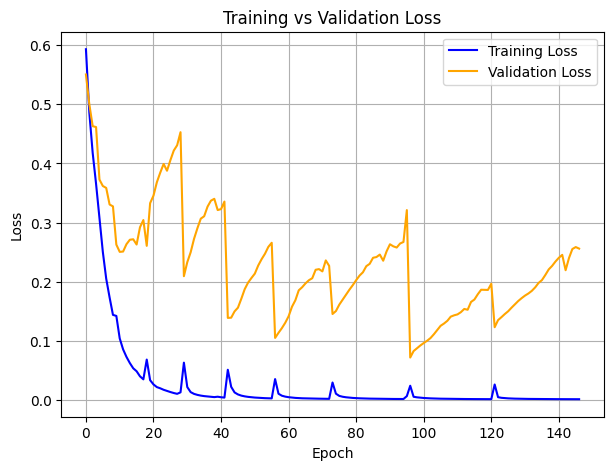

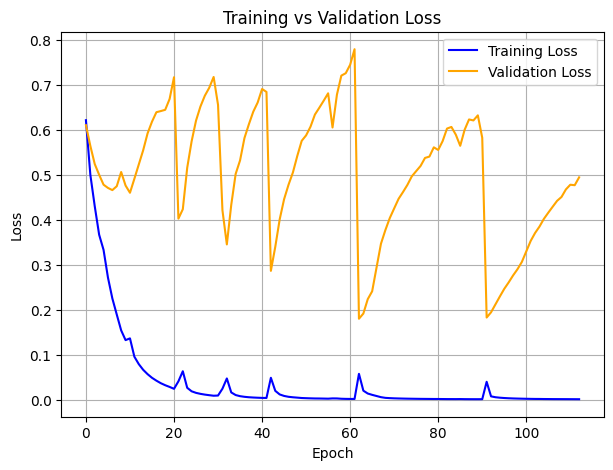

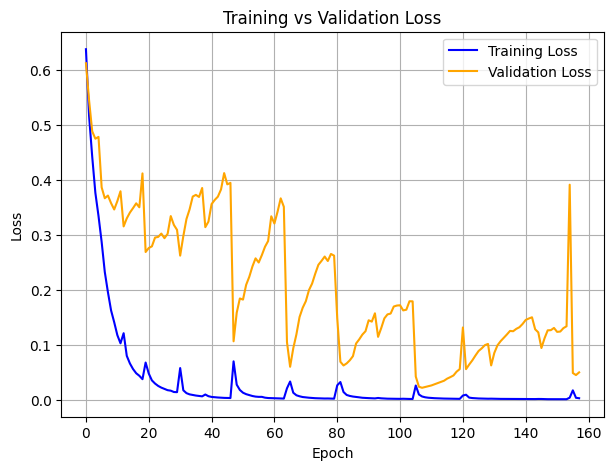

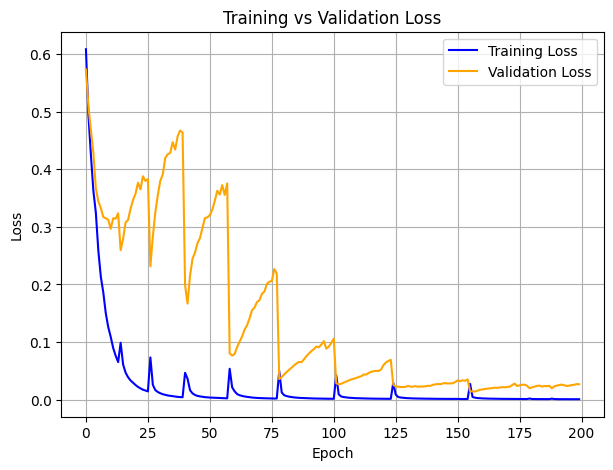

In [20]:
## Execution
from dataArrange import dataRearrange1
## Test Learn_EA without annealing
# training transformations and augmentations

transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)

])

# random seed
random_seed = 0

X = file_names_with_prefix(data_dir, 'N')

y_file_names = file_names_with_prefix(labeled_dir, 'N')


y = [label_group[:2] for label_group in y_file_names]

X = np.array(X)
y = np.array(y)

print(X)
print(y)


if CROSS_VAL:
    skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True)
    # each case same division
    #skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # if fold != 4:
        #      continue
        # Split the data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Split the training data further into train and validation ( 1/3 split)
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
        
        
        input_train = X_train_final
        input_name_val = X_val
        print("Cross validation: " + str(CROSS_VAL))
        print(f"Fold: {fold} out of {N_SPLIT}")
        print("Augmentation: " + str(AUGMENTED))
        if AUGMENTED:
            print("Augmentation amount: " + str(AUGMENTATION))
        print("Training: Total of " + str(len(input_train)) + " cases.")
        print(input_train)

        print("Validation: Total of " + str(len(input_name_val)) + " cases.")
        print(input_name_val)
        
        print("Test: Total of " + str(len(X_test)) + " cases.")  
        print(X_test)
        print()
        
        if AUGMENTED:
            ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
            ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
            repeated_items_train = np.repeat(input_train, AUGMENTATION)
            suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
            input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
            #Custom Arranging for training dataset because of the augmentation order
            input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
            repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
            suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
            input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
        
        
        #input_dataset,label_dataset = CreateWeightImageNew(input_train, augmentation=AUGMENTED)
        input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
        input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
         
        
        Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, fold)
        mConv_predict(X_test, fold)
        
        # Force garbage collection
        gc.collect()

        # Clear CUDA memory
        torch.cuda.empty_cache()

        # Optionally reset max memory tracking
        torch.cuda.reset_peak_memory_stats()
        
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
    
    X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
    
    input_train = X_train_final
    input_name_val = X_val
    
    print("Cross validation: " + str(CROSS_VAL))
    print("Augmentation: " + str(AUGMENTED))
    if AUGMENTED:
        print("Augmentation amount: " + str(AUGMENTATION))
    print("Training: Total of " + str(len(input_train)) + " cases.")
    print(input_train)

    print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    print(input_name_val)
        
    print("Test: Total of " + str(len(X_test)) + " cases.")  
    print(X_test)
    print()
    
    if AUGMENTED:
        ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
        ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
        repeated_items_train = np.repeat(input_train, AUGMENTATION)
        suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
        input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
        
        #Custom Arranging for training dataset because of the augmentation order
        input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
        repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
        suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
        input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
    
    input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
    input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
    
    
    
    # # ### lastly added for weig
    # ht management
    # weights = weights.view(1, 1, 1, -1)  # Reshape for broadcasting
    
    # #making pytorch tensor
    # input_dataset = torch.tensor(input_dataset, dtype=torch.float32)
    # input_dataset_val = torch.tensor(input_dataset_val, dtype=torch.float32)
    # weights = torch.tensor(weights, dtype=torch.float32)
    
    # input_dataset = input_dataset * weights
    # input_dataset_val = input_dataset_val * weights
    # input_dataset = input_dataset.numpy()
    # input_dataset_val = input_dataset_val.numpy()
    Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0)
    mConv_predict(X_test)
    
    # Force garbage collection
    gc.collect()
    #test add

    # Clear CUDA memory
    torch.cuda.empty_cache()

    # Optionally reset max memory tracking
    torch.cuda.reset_peak_memory_stats()
    
    